<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

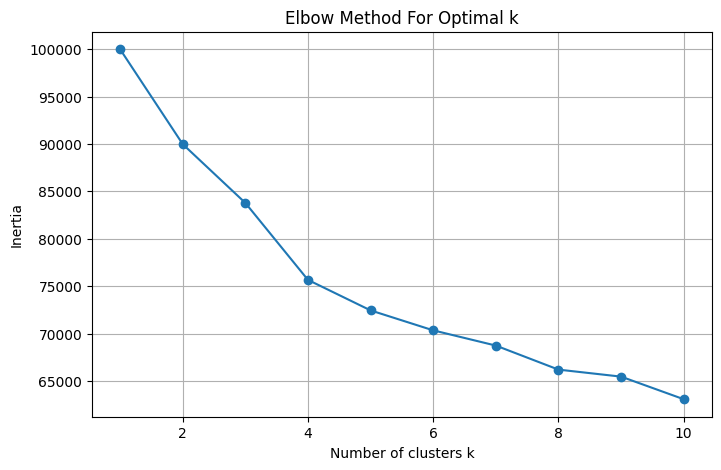

Cluster counts (KMeans):
kmeans_cluster
1    3733
0    3731
2    2536
Name: count, dtype: int64


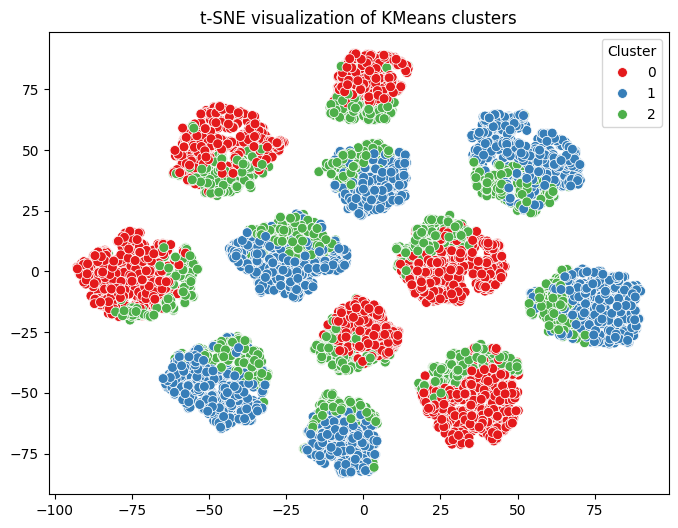

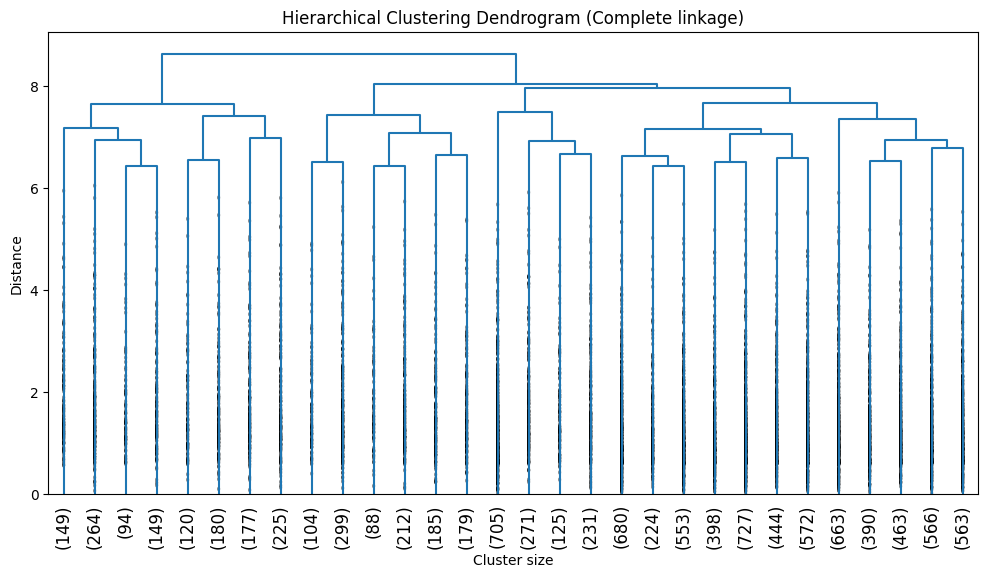

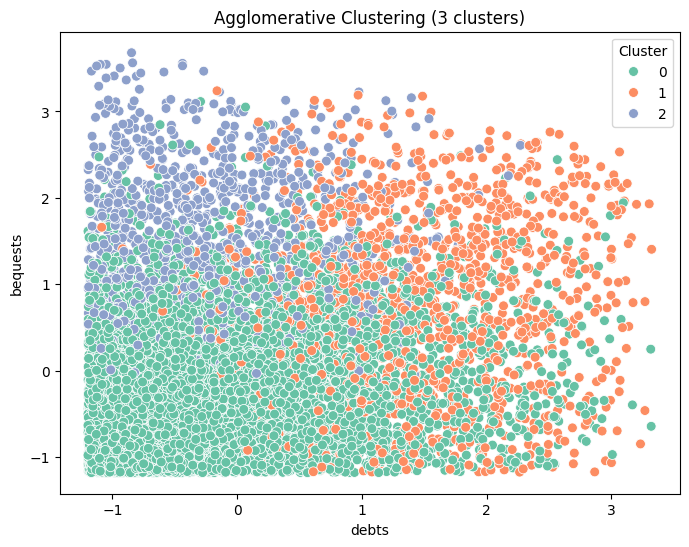

Top 10 DBSCAN parameter sets by silhouette score:
    eps  min_samples  n_clusters  n_noise  silhouette  calinski_harabasz  \
10  2.0           10          12       18    0.146452         558.643167   
11  2.0           15          12       35    0.146289         560.899477   
9   2.0            5          12        5    0.145466         557.331483   
7   1.5           10          12      961    0.131020         563.362558   
6   1.5            5          14      353    0.118216         487.499996   
8   1.5           15          13     1535    0.096305         506.801077   
5   1.0           15           3     9928   -0.192162          19.812201   
3   1.0            5         148     5161   -0.328043          28.031452   
4   1.0           10          62     9085   -0.364911          12.987068   
0   0.5            5           0    10000         NaN                NaN   

    davies_bouldin  
10        2.346559  
11        2.335120  
9         2.336011  
7         2.247021  
6       

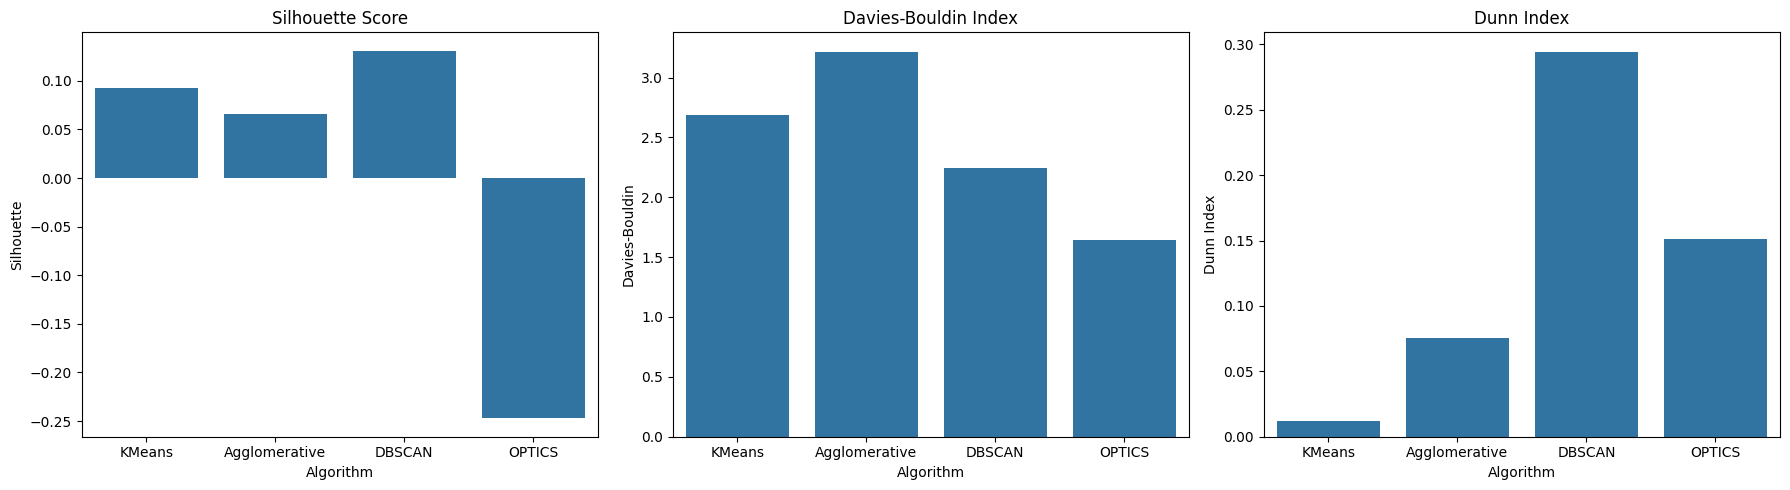

In [1]:
#----------------------------------lab6-----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cdist, pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# --- Load data ---
url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = pd.read_csv(url)

features = ['debts', 'bequests', 'wife', 'husband', 'sons', 'daughters', 'father', 'mother', 'brothers', 'sisters']
X = df[features].copy()
X.fillna(X.median(), inplace=True)

# --- Scale data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- KMeans: Elbow method to find optimal clusters ---
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# --- KMeans clustering with k=3 ---
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
df['kmeans_cluster'] = labels_kmeans
print("Cluster counts (KMeans):")
print(df['kmeans_cluster'].value_counts())

# --- t-SNE visualization of KMeans clusters ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_kmeans, palette='Set1', s=50)
plt.title('t-SNE visualization of KMeans clusters')
plt.legend(title='Cluster')
plt.show()

# --- Hierarchical clustering and dendrogram ---
plt.figure(figsize=(12, 6))
Z = linkage(X_scaled, method='complete', metric='euclidean')
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

# Agglomerative clustering with 3 clusters
agglo = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels_agglo = agglo.fit_predict(X_scaled)
df['agglo_cluster'] = labels_agglo

# Plot first two features colored by agglo clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=labels_agglo, palette='Set2', s=50)
plt.title('Agglomerative Clustering (3 clusters)')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(title='Cluster')
plt.show()

# --- DBSCAN parameter tuning ---
eps_values = np.arange(0.5, 3.0, 0.5)
min_samples_values = [5, 10, 15]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels_dbscan = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
        n_noise = list(labels_dbscan).count(-1)
        if n_clusters > 1:
            sil = silhouette_score(X_scaled, labels_dbscan)
            ch = calinski_harabasz_score(X_scaled, labels_dbscan)
            db = davies_bouldin_score(X_scaled, labels_dbscan)
        else:
            sil = ch = db = np.nan
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil,
            'calinski_harabasz': ch,
            'davies_bouldin': db
        })

results_df = pd.DataFrame(results)
print("Top 10 DBSCAN parameter sets by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False).head(10))

# --- Dunn Index calculation ---
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) <= 1 or (set(unique_clusters) == {-1}):
        return np.nan

    distances = cdist(X, X)
    intra_dists = []
    inter_dists = []

    for c in unique_clusters:
        if c == -1:
            continue
        indices = np.where(labels == c)[0]
        if len(indices) > 1:
            intra_dists.append(np.max(distances[np.ix_(indices, indices)]))

    for i in range(len(unique_clusters)):
        for j in range(i + 1, len(unique_clusters)):
            if -1 in (unique_clusters[i], unique_clusters[j]):
                continue
            i_idx = np.where(labels == unique_clusters[i])[0]
            j_idx = np.where(labels == unique_clusters[j])[0]
            inter_dists.append(np.min(distances[np.ix_(i_idx, j_idx)]))

    if intra_dists and inter_dists:
        return min(inter_dists) / max(intra_dists)
    else:
        return np.nan

# --- Compare clustering algorithms ---
algorithms = {
    'KMeans': (KMeans(n_clusters=3, random_state=42), labels_kmeans),
    'Agglomerative': (AgglomerativeClustering(n_clusters=3), labels_agglo),
    'DBSCAN': (DBSCAN(eps=1.5, min_samples=10), DBSCAN(eps=1.5, min_samples=10).fit_predict(X_scaled)),
    'OPTICS': (OPTICS(min_samples=10), OPTICS(min_samples=10).fit_predict(X_scaled))
}

metrics = []
for name, (model, labels) in algorithms.items():
    if isinstance(labels, np.ndarray):
        cluster_labels = labels
    else:
        cluster_labels = model.fit_predict(X_scaled)

    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    if n_clusters > 1:
        sil = silhouette_score(X_scaled, cluster_labels)
        db = davies_bouldin_score(X_scaled, cluster_labels)
        dunn = dunn_index(X_scaled, cluster_labels)
    else:
        sil = db = dunn = np.nan

    metrics.append({
        'Algorithm': name,
        'Clusters': n_clusters,
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Dunn Index': dunn
    })

metrics_df = pd.DataFrame(metrics)
print("\nClustering algorithm comparison:")
print(metrics_df)

# --- Plot comparison ---
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.barplot(x='Algorithm', y='Silhouette', data=metrics_df, ax=axes[0])
axes[0].set_title('Silhouette Score')

sns.barplot(x='Algorithm', y='Davies-Bouldin', data=metrics_df, ax=axes[1])
axes[1].set_title('Davies-Bouldin Index')

sns.barplot(x='Algorithm', y='Dunn Index', data=metrics_df, ax=axes[2])
axes[2].set_title('Dunn Index')

plt.tight_layout()
plt.show()
